In [332]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
# Append src directory to path
import sys
sys.path.append('C:\\Users\\kingt\\Dropbox\\Programming\\NeuralSimV3\\NeuroSimV3\\python\\src')

In [334]:
import numpy as np
import matplotlib.pyplot as plt

from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from neuron_templates import neuron_type_IZ
from network_grower import *
from network_generators import *
from neuron_type_distributor import *

## Network

In [335]:

two_node = False
three_node = False
ten_ring = False
watts_strogatz = False
geo_pref = True

if two_node:
    # Fully connected 2 neuron network
    G = nx.DiGraph()
    G.add_nodes_from([0, 1])
    # G.add_edges_from([(0, 1), (1, 0), (0, 0), (1, 1)])
    G.add_edges_from([(0, 1), (1, 0)])
elif three_node:
    # Fully connected 3 neuron network
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)])
    # G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (0, 0), (1, 1), (2, 2)])
elif ten_ring:
    # Directed ring of 10 neurons, connected to 2 nearest neighbors
    n = 20
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    G.add_edges_from([(i, (i + 1) % n) for i in range(n)])
    G.add_edges_from([(i, (i + 2) % n) for i in range(n)])
    G.add_edges_from([(i, (i - 1) % n) for i in range(n)])
    G.add_edges_from([(i, (i - 2) % n) for i in range(n)])
elif watts_strogatz:
    n = 20
    k = 4  # Each node is connected to k nearest neighbors in ring topology
    p = 0.1  # The probability of rewiring each edge
    G = nx.watts_strogatz_graph(n, k, p)
    G = G.to_directed()
elif geo_pref:
    G = spatial_pa_directed_var_out(n=50, box_dim=2, alpha=2.0, pa_gamma=1.0, local_frac=0.7,
                                kout_dist="lognormal", kout_params=(0.7, 0.9), kmin=1, seed=None)


    ensure_min_in_out(G)

    # Graph density
    print("Graph density:", nx.density(G))
    # Number of nodes and edges
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

# Small-worldedness of G
# print("Small-worldedness:", smallworld.omega(G.to_undirected(), niter=5, nrand=10))

Graph density: 0.06408163265306123
Number of nodes: 50
Number of edges: 157


In [336]:
# Small-worldedness of G
print("Small-worldedness:", smallworld.omega(G.to_undirected(), niter=2, nrand=4))

Small-worldedness: -0.02548582351067219


Text(0.5, 1.0, 'Fully Connected 2 Neuron Network')

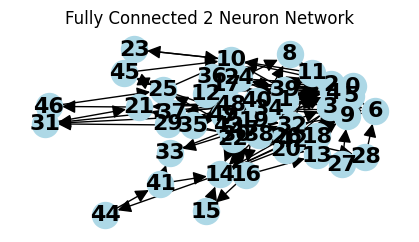

In [337]:
# Plot the network
pos = nx.spring_layout(G)
plt.figure(figsize=(4, 2))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=350, font_size=16, font_weight='bold', arrowsize=20)
plt.title("Fully Connected 2 Neuron Network")

In [372]:
# Assign all nodes to ntype ss4
# ntype = 'p23'

# for i in G.nodes:
#     G.nodes[i]['ntype'] = ntype
#     G.nodes[i]['inhibitory'] = False
#     G.nodes[i]['layer'] = 0

dist_result = assign_EI_and_subtypes_with_quotas(G, EXC_quota={"p23": 0.7, "TC": 0.3} , solver="greedy")

dist_result

{'EI_bias_used': 1.3862943611198908,
 'target_frac_exc': 0.8,
 'achieved_frac_exc': 0.74,
 'EXC_counts': {'p23': np.int64(26), 'TC': np.int64(11)},
 'INH_counts': {'TI': np.int64(3),
  'TRN': np.int64(2),
  'b': np.int64(2),
  'nb': np.int64(3),
  'nb1': np.int64(3)},
 'n_exc': 37,
 'n_inh': 13,
 'solver': 'greedy'}

In [373]:
for i in G.edges:
    u, v = i
    # Euclidean distance between node pos
    G.edges[i]['distance'] = np.linalg.norm(pos[u] - pos[v])

# Mean distance
mean_distance = np.mean([G.edges[i]['distance'] for i in G.edges])

for i in G.edges:
    u, v = i
    G.edges[i]['weight'] = 11.0
    # Random distance around 1
    distance_scale = 15.0
    # G.edges[i]['distance'] = (1 + 0.3 * (2 * random.random() - 1)) * distance_scale
    # Normalized distance and multiply by distance scale
    G.edges[i]['distance'] = G.edges[i]['distance'] / mean_distance * distance_scale
    G.edges[i]['dendritic'] = False

In [374]:
# print(G.nodes(data=True))
# print(G.edges(data=True))

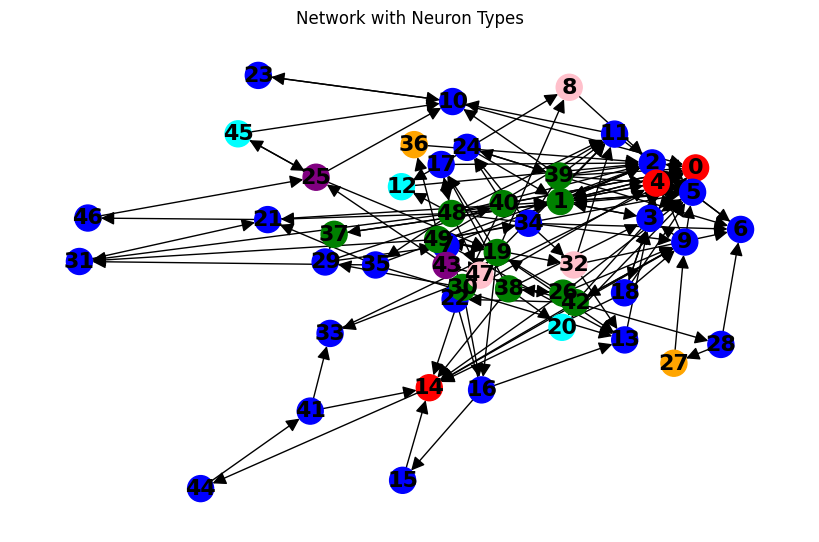

In [375]:
# Plot network with node color based on ntype
ntype_colors = {
    "p23": "blue",
    "TC": "green",
    "TI": "red",
    "TRN": "purple",
    "b": "orange",
    "nb": "pink",
    "nb1": "cyan"
}

node_colors = [ntype_colors.get(G.nodes[i]['ntype'], 'gray') for i in G.nodes]
plt.figure(figsize=(8, 5))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=350, font_size=16, font_weight='bold', arrowsize=20)
plt.title("Network with Neuron Types")
plt.show()

## Simulation

In [376]:
dt = 0.1

In [377]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = ["p23", "TC", "TI", "TRN", "nb1", "b", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True, True, True, True, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [378]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

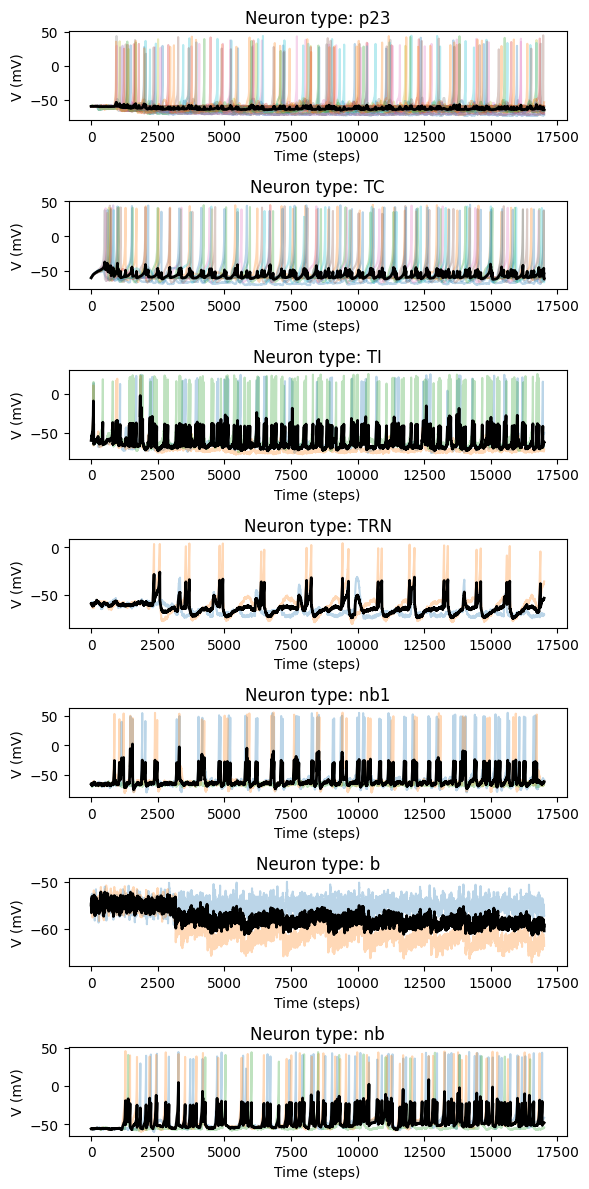

In [379]:
sim = Simulation(connectome, dt, stepper_type="adapt")

I_ext = np.zeros((pop.n_neurons))
I_ext[pop.get_neurons_from_type("TC")] = 150
I_ext[pop.get_neurons_from_type("TI")] = 50

# I_ext = 100

for i in range(1000):
    sim.step(I_ext=I_ext)

I_ext[:] = 0

for i in range(16000):
    sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 12))

In [380]:
sim.stats.compute_metrics(dt)

{'rate_mean_Hz': 8.87006646667843,
 'rate_median_Hz': 4.411505205576142,
 'rate_p95_Hz': 31.821657549555905,
 'ISI_CV_median': 0.31312966875095294,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_300ms': 0.5,
 'mean_noise_corr_50ms': 0.0034958788530660536,
 'pop_spec_entropy': 8.611337829144485}

In [381]:
connectome.compute_metrics()

{'smallworld_omega': -0.04117553360942994,
 'spectral_radius': 56.424384010823275,
 'n_nodes': 50,
 'n_edges': 157,
 'n_E': 37,
 'n_I': 13,
 'k_in_mean': 3.14,
 'k_out_mean': 3.14,
 's_in_mean': 34.54,
 's_out_mean': 34.54,
 'k_in_std': 3.181643780006986,
 'k_out_std': 2.2315913604421396,
 's_in_std': 34.99808158007684,
 's_out_std': 24.547504964863535,
 'edge_frac_EE': 0.5923566878980892,
 'edge_frac_EI': 0.21656050955414013,
 'edge_frac_IE': 0.1464968152866242,
 'edge_frac_II': 0.044585987261146494,
 'reciprocity': 0.3057324840764331,
 'assort_out_to_in_degree': 0.005436106856870322,
 'assort_outStrength_to_inStrength': 0.00543610685687036,
 'clustering_avg_weighted': 0.2885194805194805,
 'transitivity_unweighted': 0.28337531486146095,
 'rich_club_phi_k': 1.0,
 'rich_club_k_sel': 9,
 'triadic_census': {'003': 13935,
  '012': 4154,
  '102': 867,
  '021D': 122,
  '021U': 137,
  '021C': 114,
  '111D': 147,
  '111U': 40,
  '030T': 34,
  '030C': 2,
  '201': 9,
  '120D': 9,
  '120U': 5,
  

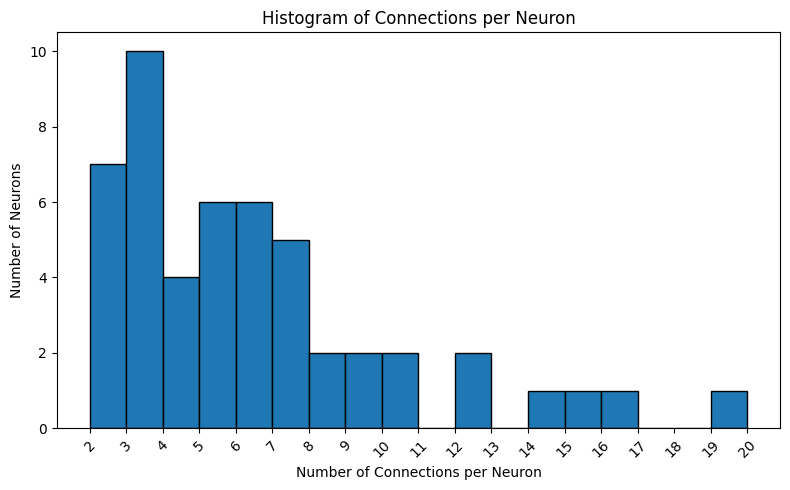

(array([ 7, 10,  4,  6,  6,  5,  2,  2,  2,  0,  2,  0,  1,  1,  1,  0,  0,
         1]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20.]))

In [382]:
connectome.plot_connections_histogram()

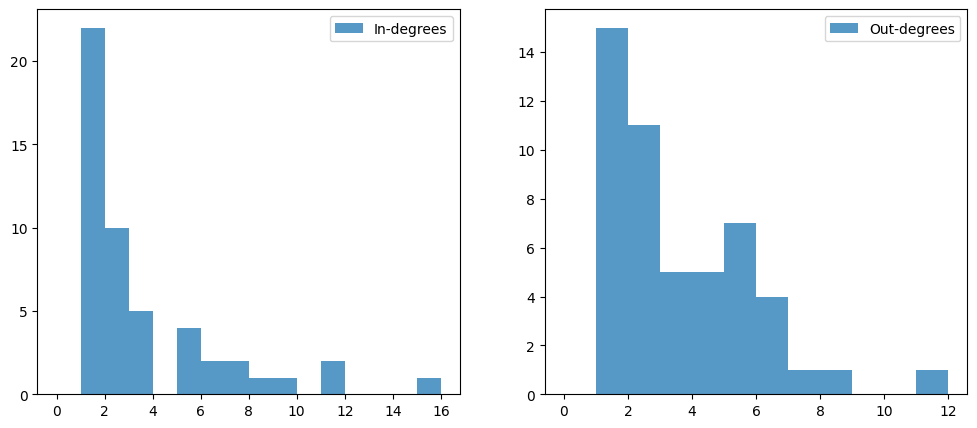

In [383]:
# Histogram of in-degrees and out-degrees
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(max(in_degrees) + 2), alpha=0.75, label='In-degrees')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(max(out_degrees) + 2), alpha=0.75, label='Out-degrees')
plt.legend(loc='upper right')